# Study of Exploration Algorithms in developmental robotics with Explauto

This tutorial explains and implements some exploration algorithms in developmental robotics.  
The goal is to get used to the concepts of Goal Babbling, Active Learning based on learning progress and Model Babbling, by experimenting with those strategies in simple environments composed of a robotic arm interacting with objects.  
We use the [Explauto](https://github.com/flowersteam/explauto) Python library as a toolkit to help implement exploration algorithms.

The progression is the following:

    I.   Exploring by hand the movements of a robotic arm
    II.  Random Motor Babbling
    III. Random Goal Babbling
    IV.  Active Goal Babbling
    V.   More complex environment
    VI.  Active Model Babbling

### Requirements:

- Python 2.7, Numpy, Scipy, Scikit-learn and [Jupyter](http://jupyter.readthedocs.io/en/latest/install.html). For users not familiar with Python, installing [Anaconda](https://www.continuum.io/downloads) for Python 2.7 includes all of them.
- [Explauto](https://github.com/flowersteam/explauto), the Python Library for Autonomous Exploration. See [installation](http://flowersteam.github.io/explauto/installation.html) section: the simplest is to install explauto via pip: 'pip install explauto'.

You might need to run 'jupyter nbextension enable --py --sys-prefix widgetsnbextension' to enable the interaction with sliders in part I.


To run this notebook, run the following command in the ExplorationAlgorithm folder:

    jupyter notebook main.ipynb
    
    
Let's begin with the import of all the classes and functions we will need in this notebook.

In [4]:
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
from numpy import pi, array, linspace, hstack, zeros, transpose
from matplotlib import animation
from IPython.display import HTML, display, Image
from ipywidgets import interact_manual
from numpy.random import random, normal

from explauto import SensorimotorModel
from explauto.sensorimotor_model.non_parametric import NonParametric
from explauto import InterestModel
from explauto.interest_model.discrete_progress import DiscretizedProgress
from explauto.utils import rand_bounds, bounds_min_max, softmax_choice, prop_choice
from explauto.environment.dynamic_environment import DynamicEnvironment
from explauto.interest_model.competences import competence_exp, competence_dist
from explauto.environment.modular_environment import FlatEnvironment, HierarchicalEnvironment

from environment import Arm, Ball, Stick, Environment1, Environment2, Environment3
from learning_module import LearningModule
from utils import compute_explo

grid_size = 10



def display_movement(fig, ax, environment, time_step=0.04):
    fig.show()
    fig.canvas.draw()
    ax.set_aspect('equal')
    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1.5, 1.5))
    background = fig.canvas.copy_from_bbox(ax.bbox)

    for i in range(50):
        start = time.time()
        fig.canvas.restore_region(background)
        lines = environment.env.plot_update(ax, i)
        for line in lines:
            ax.draw_artist(line)
        fig.canvas.blit(ax.bbox)

        end = time.time()
        remain = start + time_step - end
        if remain > 0:
            time.sleep(remain)
    time.sleep(2)
            
print "My backend:", matplotlib.get_backend()

My backend: TkAgg


-------------------------------
#  I. Exploring by hand the movements of a robotic arm

This first part is designed to have a first experience of the complexity of the task given to the robot, by the exploration of the motor parameters by hand.

The 3 joints of the robotic arm are controlled through DMPs with 3 basis functions, which results in 9 motor parameters in total that produce a movement of the arm. You can control those parameters by hand through the 9 following sliders (move the sliders and then hit "Run" button).

Try to catch the ball !

In [2]:
# Had to run 'jupyter nbextension enable --py --sys-prefix widgetsnbextension'

fig, ax = plt.subplots()
environment1 = Environment1()

def movement(m1=0., m2=0., m3=0., m4=0., m5=0., m6=0., m7=0., m8=0., m9=0.):
    environment1.update(array([m1, m2, m3, m4, m5, m6, m7, m8, m9]))
    display_movement(fig, ax, environment1)
    
interact_manual(movement, m1=(-1., 1., 0.01), m2=(-1., 1., 0.01), m3=(-1., 1., 0.01), 
                          m4=(-1., 1., 0.01), m5=(-1., 1., 0.01), m6=(-1., 1., 0.01), 
                          m7=(-1., 1., 0.01), m8=(-1., 1., 0.01), m9=(-1., 1., 0.01))


-------------------------------
#  II. Random Motor Babbling

Now, let's use a higher dimensional arm (7 joints and 21 motor parameters), and see how the robot could explore its arm  by just trying a lot of different random motor configurations, which is called Random Motor Babbling.

In the following, we do 1000 iterations of Random Motor Babbling and for each iteration, if the ball was caught by the arm, we plot the trajectory of the ball (line) and its last position (ball).

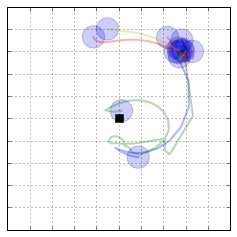

In [10]:
%matplotlib inline
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-1., 1.))
ax.set_ylim((-1., 1.))
ax.plot(0., 0., 'sk', ms=8)
explored_s_mb = []

environment2 = Environment2()

for _ in range(1000):
    m = environment2.random_motors()[0]
    s = environment2.update(m)
    if abs(s[-1] - 0.6) > 0.001:
        explored_s_mb += [s]
        ax.plot(environment2.s_traj[:,0], environment2.s_traj[:,1], lw=2, alpha=0.3)
        ax.add_patch(Circle(tuple(environment2.s_traj[-1,:]), 0.1, fc="b", alpha=0.2))
        
plt.xticks(linspace(-1., 1., grid_size + 1))
plt.yticks(linspace(-1., 1., grid_size + 1))
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.grid()

### Exploration measure
We compute the number of cells in the above grid where the ball has been placed at the end of the different movements.

In [11]:
print "Number of ball catch:", len(explored_s_mb)
print "Number of reached cells:", int(compute_explo(array(explored_s_mb), array([-1., -1.]), array([1., 1.]), gs=grid_size))

Number of ball catch: 14
Number of reached cells: 7


We can see that the ball has been caught only a few times and that a small number of cells have been reached with the ball.

-------------------------------
#  III. Random Goal Babbling

Goal babbling consists in choosing goals in the sensory space and using the current state of the model of the environment (the sensorimotor model) to infer a motor action supposed to reach the goals (inverse prediction). The robot then executes the command through the environment and observes the actual sensory effect. The sensorimotor model is finally updated according to this experience.

In the Explauto library, there are different algorithms available to perform inverse prediction from the database of sensorimotor experience.  
Here we will use the Nearest Neighbor algorithm. This sensorimotor model simply stores sensorimotor experience, ie. (m,s)
pairs where m are motor commands (here arm joint positions) and s are the corresponding sensory effects (here ball end positions).  
When asked for an inverse prediction to reach a sensory goal s, it returns the motor command m associated to the nearest neighbor of s in the stored sensory experience, and adds some exploration noise (gaussian with standard deviation 'sigma_explo_ratio').


In Random Goal Babbling, the goals are choosen randomly in the sensory space, thus the bounds of the space are important.  
Here the arm can reach the circle of radius 1, and we define the sensory space as the square of size 10, meaning that a lot of this space is unreachable. When the robot chooses an unreachable goal, it will explore the closest reachable points.

Number of ball catch: 806
Number of reached cells: 41


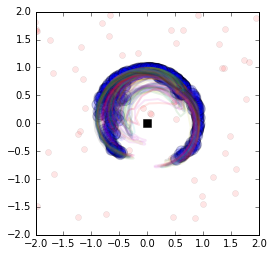

In [12]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-2., 2.))
ax.set_ylim((-2., 2.))
ax.plot(0., 0., 'sk', ms=8)
explored_s_gb = []

sm_model = SensorimotorModel.from_configuration(environment2.conf, 'nearest_neighbor', 'default')
sigma_explo_ratio = 0.05

# Bootstrap model: 1 random motor babbling
m = environment2.random_motors()[0]
s = environment2.update(m)
sm_model.update(m, s)
    
for _ in range(2000):
    if (not sm_model.bootstrapped_s) or random() < 0.2:
        m = environment2.random_motors()[0]
    else:
        s_goal = rand_bounds(environment2.conf.s_bounds)[0]
        # infer a motor command to reach that goal using the Nearest Neighbor algorithm:
        m = sm_model.model.infer_order(tuple(s_goal))
        # add exploration noise (of variance sigma) to experiment new motor parameters
        m = normal(m, sigma_explo_ratio)
        #Plot the goal
        ax.plot([s_goal[0]], [s_goal[1]], 'or', alpha=0.1)
        
    s = environment2.update(m)
    sm_model.update(m, s)
    if abs(s[-1] - 0.6) > 0.001:
        explored_s_gb += [s]
        ax.plot(environment2.s_traj[:,0], environment2.s_traj[:,1], lw=2, alpha=0.1)
        ax.add_patch(Circle(tuple(environment2.s_traj[-1,:]), 0.1, fc="b", alpha=0.2))
        
print "Number of ball catch:", len(explored_s_gb)
print "Number of reached cells:", int(compute_explo(array(explored_s_gb), array([-1., -1.]), array([1., 1.]), gs=grid_size))

Random Goal Babbling allows a progressive covering of the reachable sensory space, more efficiently than in a motor babbling strategy, where the agent samples directly in the motor space.

-------------------------------
# IV. Active Goal Babbling

Active learning can be helpful.

Number of ball catch: 823
Number of reached cells: 60


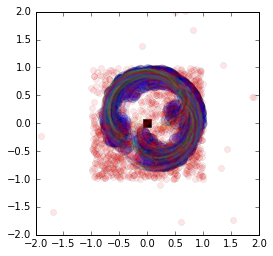

In [13]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-2, 2.))
ax.set_ylim((-2., 2.))
ax.plot(0., 0., 'sk', ms=8)
explored_s_agb = []


sm_model = SensorimotorModel.from_configuration(environment2.conf, 'nearest_neighbor', 'default')
sigma_explo_ratio = 0.05

im_n_cells = 20
im_model = DiscretizedProgress(environment2.conf, environment2.conf.s_dims, 
                               **{'x_card': im_n_cells*im_n_cells, 
                                  'win_size': 20, 
                                  'eps_random': 0.2,
                                  'measure': competence_dist})

# Bootstrap model: 1 random motor babbling
m = environment2.random_motors()[0]
s = environment2.update(m)
sm_model.update(m, s)
    
for _ in range(2000):
    if (not sm_model.bootstrapped_s) or random() < 0.2:
        m = environment2.random_motors()[0]
        s = environment2.update(m)
        sm_model.update(m, s)
    else:
        # sample a sensory goal maximizing learning progress using the interest model:
        s_goal = im_model.sample()
        # infer a motor command to reach that goal using the Nearest Neighbor algorithm:
        m = sm_model.model.infer_order(tuple(s_goal))
        # add exploration noise (of variance sigma) to experiment new motor parameters
        m = normal(m, sigma_explo_ratio)
        # execute this command and observe the corresponding sensory effect:
        s = environment2.update(m)
        # update the sensorimotor model:
        sm_model.update(m, s)
        # update the interest model:
        im_model.update(hstack((m, s_goal)), hstack((m, s)))
        #Plot the goal
        ax.plot([s_goal[0]], [s_goal[1]], 'or', alpha=0.1)
    # plot the observed sensory effect:
    if abs(s[-1] - 0.6) > 0.001:
        explored_s_agb += [s]
        ax.plot(environment2.s_traj[:,0], environment2.s_traj[:,1], lw=2, alpha=0.1)
        ax.add_patch(Circle(tuple(environment2.s_traj[-1,:]), 0.1, fc="b", alpha=0.2))

print "Number of ball catch:", len(explored_s_agb)
print "Number of reached cells:", int(compute_explo(array(explored_s_agb), array([-1., -1.]), array([1., 1.]), gs=grid_size))

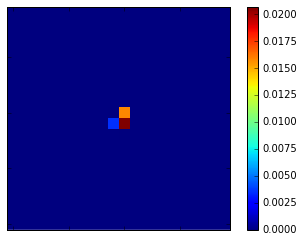

In [14]:
progress_flat = abs(im_model.discrete_progress.progress())
progress_array = zeros(im_model.space.cardinalities)

for idx in range(len(progress_flat)):
    progress_array[im_model.space.index2multi(idx)] = progress_flat[idx]
    #print "xy", im_model.space.index2multi(idx), "progress", progress_flat[idx], im_model.discrete_progress.queues[idx]

from matplotlib import cm
fig, ax = plt.subplots()
ax.set_xticklabels([])
ax.set_yticklabels([])
cax = ax.imshow(transpose(progress_array), origin='lower', cmap=cm.jet, interpolation="none")
fig.colorbar(cax)


RGB seems as good as AGB. 

Intuition: normally RGB explores more the frontier and has trouble to reach the inside, but here it could be that from a point reaching the frontier, the random exploration noise easily allows to reach the inside (it is sufficient to change only one of 14 parameters, or even combinations of them).

-------------------------------
# V. More complex environment

In the previous environments, the exploration of the sensory variables lead to interesting learning, but in more realistic environments that might not be the case. We define here a similar environment with objects that are not interesting to interact with, either because they are too easy to learn, or because they are not learnable.

The environment is composed of the same 21 parameters arm plus a stick that can be used as a tool to move a blue ball (the ball can't be grasped by the hand anymore).  
We also add a static magenta ball that can't be move in any way, and 2 random balls that do a random walk.

In the following, we display 1 random movement of the arm, and 1 movement tuned to reach the tool and move the blue ball with the tool.  
The probability of getting the tool and moving the blue ball with a random movement (in 21D) is around 1 out of 10000.

In [9]:
# Try to put to your default backend, or restart kernel and re-run import code (first block)
%matplotlib tk
fig, ax = plt.subplots()

# Create new environment
environment3 = Environment3()

In [11]:
# 1 iteration of Random Motor Babbling
m = environment3.random_motors()[0]
s = environment3.update(m)
display_movement(fig, ax, environment3, time_step=0.1)

In [12]:
# Example of motor parameters to catch the ball (around 1 out of 10000 random motor parameters)
m = [ 0.54984069,  0.02455233, -0.59603529, -0.6655813,   0.33923315,  0.22605509,
  0.81641894, -0.26901228,  0.14363993, -0.71148838,  0.10504532,  0.58099297,
 -0.80227669,  0.48208766, -0.56107818, -0.68042166,  0.9648434,  -0.8760082,
 -0.19469749, -0.6141873,   0.11389673]
s = environment3.update(m)
display_movement(fig, ax, environment3, time_step=0.1)

Let's try the Random Goal Babbling exploration strategy in this environment.
The motor space is the same as before (21 dimensions), and the sensory space is composed of the trajectories of the arm, tool and the 3 balls (6 dimensions for each object, so 36 dimensions):

Number of tool catch: 555
Number of cells reached with tool: 26
Number of ball catch: 2
Number of cells reached with ball: 1


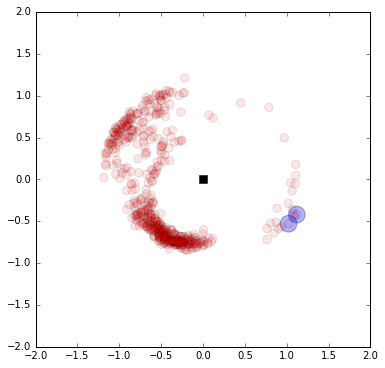

In [58]:
%matplotlib inline
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-2, 2.))
ax.set_ylim((-2., 2.))
ax.plot(0., 0., 'sk', ms=8)
explored_s_agb_t = []
explored_s_agb_o = []

def plot_s(s):
    global explored_s_agb_t, explored_s_agb_o
    if abs(s[17] - 0.6) > 0.001:
        explored_s_agb_o += [[s[14], s[17]]]
        ax.add_patch(Circle(tuple(environment3.s_traj[-1,4:6]), 0.1, fc="b", alpha=0.3))
    if abs(s[11] - 0.46213203) > 0.001:
        explored_s_agb_t += [[s[8], s[11]]]
        ax.add_patch(Circle(tuple(environment3.s_traj[-1,2:4]), 0.05, fc="r", alpha=0.1))
        
        
sm_model = SensorimotorModel.from_configuration(environment3.conf, 'nearest_neighbor', 'default')
sigma_explo_ratio = 0.05


# Bootstrap model: 1 random motor babbling
m = environment3.random_motors()[0]
s = environment3.update(m)
sm_model.update(m, s)
    
for _ in range(20000):
    if (not sm_model.bootstrapped_s) or random() < 0.2:
        m = environment3.random_motors()[0]
        s = environment3.update(m)
        sm_model.update(m, s)
    else:
        # sample a sensory goal maximizing learning progress using the interest model:
        s_goal = rand_bounds(environment3.conf.s_bounds)[0]
        # infer a motor command to reach that goal using the Nearest Neighbor algorithm:
        m = sm_model.model.infer_order(tuple(s_goal))
        # add exploration noise (of variance sigma) to experiment new motor parameters:
        m = normal(m, sigma_explo_ratio)
        # execute this command and observe the corresponding sensory effect:
        s = environment3.update(m)
        # update the sensorimotor model:
        sm_model.update(m, s)
    plot_s(s) # plot the observed sensory effect

#plt.savefig('explored_RGB_100000it')
        
print "Number of tool catch:", len(explored_s_agb_t)
print "Number of cells reached with tool:", int(compute_explo(array(explored_s_agb_t), array([-2., -2.]), array([2., 2.]), gs=grid_size))
print "Number of ball catch:", len(explored_s_agb_o)
print "Number of cells reached with ball:", int(compute_explo(array(explored_s_agb_o), array([-2., -2.]), array([2., 2.]), gs=grid_size))

The following image shows an example of exploration for 100000 iterations (10min) of Random Goal Babbling.  
The number of cells reached with the ball was 11.

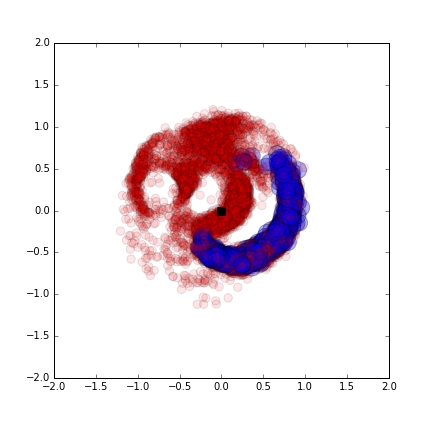

In [52]:
Image('./explored_RGB_100000it.png')

Here there are 36 sensory dimensions, and Goal Babbling chooses random goals in this space, where most of the space is unreachable (or uncontrollable: the random balls). This strategy thus fail to explore interesting parts of the sensory space, and only few cells are reached with the controllable ball.  

Active Goal Babbling can't directly help here in 36 dimensions because a discretization of this space would have way too much cells.  
Therefore, we need to change the representation of this space in order to discriminate the variables that are controllable from random variables, and to define smaller-dimensional but interesting sensory spaces.

-------------------------------
# VI. Model Babbling

Use algo and interest measure from IROS

To measure the interest of each module, we pick one module, pick one random goal in its sensory space, and do 5 iterations with this goal: 4 with gaussian exploration noise, and 1 without noise, which gives an unperturbated reached sensory point used to compute errors and progress.

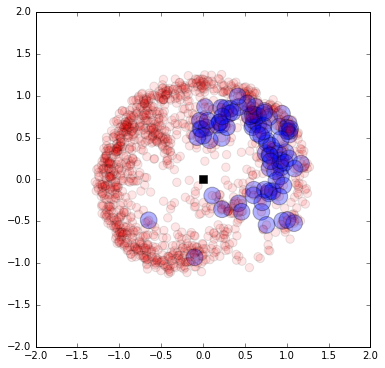

In [54]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim((-2, 2.))
ax.set_ylim((-2., 2.))
ax.plot(0., 0., 'sk', ms=8)
explored_s_agb_t = []
explored_s_agb_o = []
interests_evolution = []
n_explore = 4

def plot_s(s):
    global explored_s_agb_t, explored_s_agb_o
    if abs(s[17] - 0.6) > 0.001:
        explored_s_agb_o += [[s[14], s[17]]]
        ax.add_patch(Circle(tuple(environment3.s_traj[-1,4:6]), 0.1, fc="b", alpha=0.3))
    if abs(s[11] - 0.46213203) > 0.001:
        explored_s_agb_t += [[s[8], s[11]]]
        ax.add_patch(Circle(tuple(environment3.s_traj[-1,2:4]), 0.05, fc="r", alpha=0.1))
        
    
# Create environment:
environment3 = Environment3()

# Define motor and sensory spaces:
m_space = range(21)
s_hand  = range(21, 27)
s_tool  = range(27, 33)
s_ball1 = range(33, 39)
s_ball2 = range(39, 45)
s_ball3 = range(45, 51)
s_ball4 = range(51, 57)

# Create 6 learning modules:
learning_modules = {}
learning_modules['mod1'] = LearningModule("mod1", m_space, s_hand, environment3.conf)
learning_modules['mod2'] = LearningModule("mod2", m_space, s_tool, environment3.conf)
learning_modules['mod3'] = LearningModule("mod3", m_space, s_ball1, environment3.conf)
learning_modules['mod4'] = LearningModule("mod4", m_space, s_ball2, environment3.conf)
learning_modules['mod5'] = LearningModule("mod5", m_space, s_ball3, environment3.conf)
learning_modules['mod6'] = LearningModule("mod6", m_space, s_ball4, environment3.conf)


# 1000 steps of (4 exploring and 1 exploiting iterations):
for step in range(20000 / (n_explore + 1)):
    interests = [learning_modules[mid].interest() for mid in learning_modules.keys()] # compute the interest of modules
    interests_evolution.append(interests)
    # choose the babbling module (probabilities proportional to interests, with epsilon of random choice):
    babbling_module = learning_modules.values()[prop_choice(interests, eps=0.2)]
    # the babbling module picks a random goal in its sensory space and returns 4 noisy motor commands:
    m_list = babbling_module.produce(n=n_explore)
    for m in m_list:
        s = environment3.update(m) # execute this command and observe the corresponding sensory effect
        plot_s(s) # plot the observed sensory effect
        # Update sensorimotor models:
        for mid in learning_modules.keys():
            learning_modules[mid].update_sm(m, learning_modules[mid].get_s(array(list(m) + list(s))))
    # choose the best motor command to reach current goal (with no noise):
    m = babbling_module.infer(babbling_module.expl_dims, babbling_module.inf_dims, babbling_module.x, n=1, explore=False)    
    s = environment3.update(m) # execute this command and observe the corresponding sensory effect
    # update the 5 sensorimotor models and the interest model of the babbling module:
    for mid in learning_modules.keys():
        learning_modules[mid].perceive(m, learning_modules[mid].get_s(array(list(m)+list(s))), mid==babbling_module.mid)
        

#plt.savefig('explored_AMB_100000it')

In [56]:
for mid in learning_modules.keys():
    print "Number of babbling steps for module", mid, ":", learning_modules[mid].im.n_points(), "{}%".format(int(100. * (n_explore + 1)*learning_modules[mid].im.n_points() / float(learning_modules[mid].sm.t)))
print
    
        
print "Number of tool catch:", len(explored_s_agb_t)
print "Number of cells reached with tool:", int(compute_explo(array(explored_s_agb_t), array([-2., -2.]), array([2., 2.]), gs=grid_size))
print "Number of ball catch:", len(explored_s_agb_o)
print "Number of cells reached with ball:", int(compute_explo(array(explored_s_agb_o), array([-2., -2.]), array([2., 2.]), gs=grid_size))

Number of babbling steps for module mod1 : 2025 50%
Number of babbling steps for module mod2 : 1032 25%
Number of babbling steps for module mod3 : 278 6%
Number of babbling steps for module mod4 : 124 3%
Number of babbling steps for module mod5 : 206 5%
Number of babbling steps for module mod6 : 325 8%

Number of tool catch: 1305
Number of cells reached with tool: 42
Number of ball catch: 90
Number of cells reached with ball: 15


AMB explores better than F-RGB

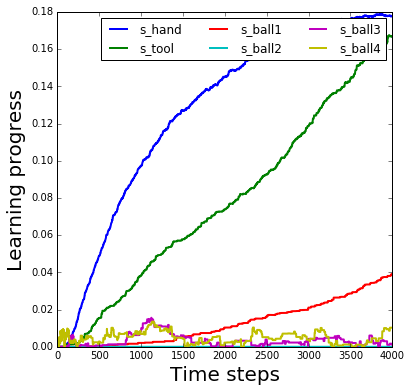

In [57]:
fig, ax = plt.subplots()
ax.plot(array(interests_evolution), lw=2)
ax.legend(["s_hand", "s_tool", "s_ball1", "s_ball2", "s_ball3", "s_ball4"], ncol=3)
ax.set_xlabel('Time steps', fontsize=20)
ax.set_ylabel('Learning progress', fontsize=20)
#plt.savefig('learning_progress_AMB_100000it')

The interest of the static ball is always 0.
The interest of random balls is small.
The interest of hand is high at the beginning and allows to explore movements of the hand and to discover the tool (no other motor babbling).

The following image, on the right, shows an example of exploration for 100000 iterations (10min).
The number of cells reached with the ball was 35.

In [45]:
display(HTML("<img style='width: 400px; margin: 0px; float: left; border: 1px solid black;' src='./learning_progress_AMB_100000it.png' /> <img style='width: 400px; margin: 0px; float: left; border: 1px solid black;' src='./explored_AMB_100000it.png' />"))